In [1]:
from datasets.nuscenes import compile_data as compile_data, denormalize_img
import yaml
import matplotlib.pyplot as plt
import torch

In [2]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from PIL import Image

In [3]:
with open("./configs/eval_nuscenes_cvt_enn.yaml", 'r') as file:
    config = yaml.safe_load(file)
    
config['batch_size'] = 1
config['num_workers'] = 1
   
train_loader, val_loader = compile_data("trainval", config, shuffle_train=True, ood=True)

Flipped: False
Dims: (224, 480)
../data/nuscenes/trainval
OOD labels: ['vehicle.bus.rigid', 'vehicle.bus.bendy']
OOD labels: ['vehicle.bus.rigid', 'vehicle.bus.bendy']


In [25]:
t = iter(val_loader)
imgs, rots, trans, intrins, extrins, post_rots, post_trans, labels, ood, ood_cam = next(t)

In [35]:
hw = [
    (56, 120),
    (14, 30),
]

H, W = 25, 25



In [27]:
from models.cvt.cross_view_transformer import *

cvt = torch.nn.DataParallel(CrossViewTransformer(outC=4), device_ids=[0])
cvt.load_state_dict(torch.load("./nuscenes/cvt_enn/best_iou.pt"))

Initializing CVT model
Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [30]:
preds, atts = cvt(imgs, rots, trans, intrins, extrins, post_rots, post_trans, return_att=True)

torch.Size([4, 625, 40320])
25 25


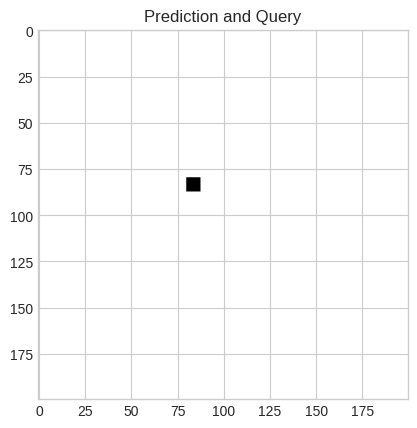

(0, 7, 16)
0.020648003


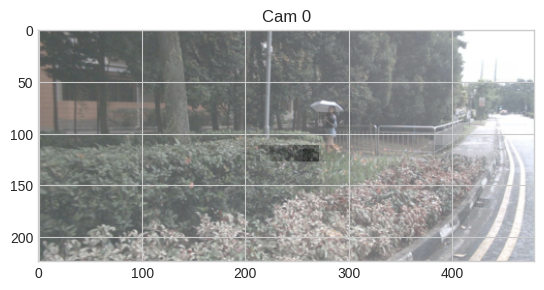

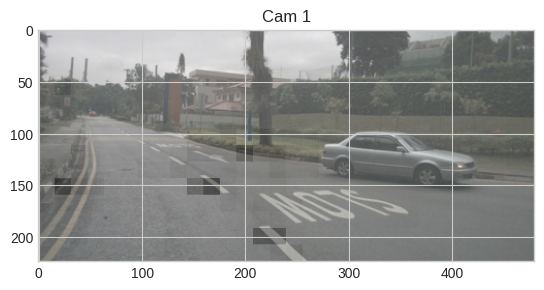

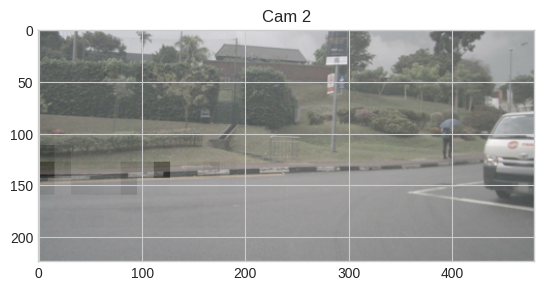

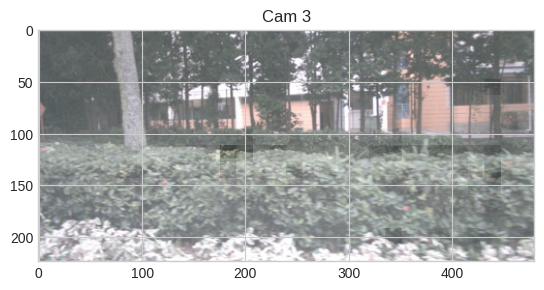

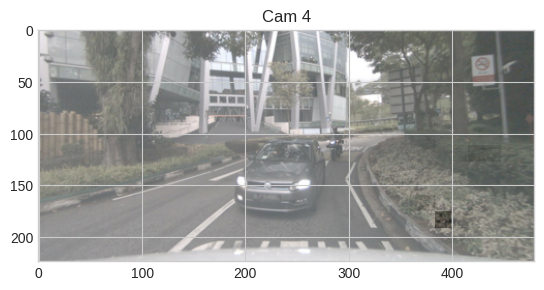

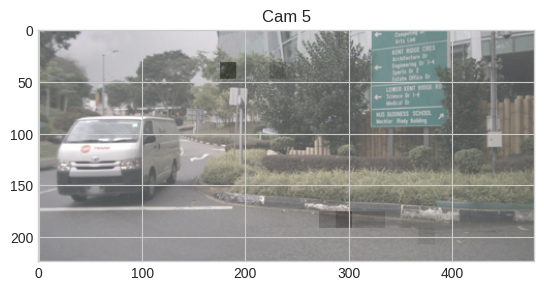

In [66]:

rearranged_atts = []
print(atts[0].shape)
print(W, H)
for i, att in enumerate(atts):
    r = rearrange(att, '(b m) (H W) (n h w) -> b m H W n h w', n=6, m=4, H=H, W=W, h=hw[i][0],
                              w=hw[i][1])
    rearranged_atts.append(r) 

# Visualization
att = rearranged_atts[-1]  # get the last attention layer
att = att[0].detach()  # batch size is 1, we remove the batch dim here.
mean_att = torch.mean(att, dim=0)
preds = preds.softmax(dim=1)
# pred, labels = save_pred(preds, labels, './')

cam_img = np.transpose(imgs[0][1].cpu().numpy(), (1, 2, 0))

query_locations = [
    (10,10)
]

for query_location in query_locations:
    att_map = mean_att[query_location[0]][query_location[1]].detach().cpu().numpy()

    pred_img = preds[0][0].detach().cpu().numpy()
    plt.title('Prediction and Query')
    plt.imshow(pred_img)
    # Query mask
    query_mask = np.zeros((H, W))
    query_mask[query_location[0], query_location[1]] = 1
    query_mask = cv2.resize(query_mask, dsize=(pred_img.shape[1], pred_img.shape[0]),
                            interpolation=cv2.INTER_NEAREST)
    plt.imshow(query_mask, alpha=query_mask)
    plt.show()

    ova = np.unravel_index(att_map.argmax(), att_map.shape)
    print(ova)
    print(att_map[ova[0], ova[1], ova[2]])

    for j in range(6):
        cam_img = np.transpose(imgs[0][j].cpu().numpy(), (1, 2, 0))
        att_map = mean_att[query_location[0]][query_location[1]][j].cpu().numpy()
        plt.title(f'Cam {j}')
        plt.imshow(cam_img)
        att_map_upsampled = cv2.resize(att_map, dsize=(cam_img.shape[1], cam_img.shape[0]),
                                       interpolation=cv2.INTER_NEAREST)
        plt.imshow(att_map_upsampled, alpha=att_map_upsampled+.25)              
        plt.show()